You are analyzing bond yield data along with macroeconomic indicators (such as inflation rate, unemployment rate, and GDP growth) to identify trends and make predictions about interest rate movements.

Perform regression analysis using scikit-learn to predict bond yields based on inflation, unemployment, and GDP growth.

In [ ]:
!pip install fredapi

In [ ]:
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Fred API with your API key
fred = Fred(api_key='f53027116eb5c484e3d9419709c2bc06')

# Fetch data
bond_yields = fred.get_series('GS10')  # 10-Year Treasury Constant Maturity Rate
inflation_rate = fred.get_series('CPIAUCSL')  # Consumer Price Index (CPI)
unemployment_rate = fred.get_series('UNRATE')  # Unemployment Rate
gdp_growth = fred.get_series('GDPC1')  # Real Gross Domestic Product

# Convert to DataFrame
df = pd.DataFrame({
    'Bond Yields': bond_yields,
    'Inflation Rate': inflation_rate,
    'Unemployment Rate': unemployment_rate,
    'GDP Growth': gdp_growth
})

# Preview the dataset
print(df.head(200))

            Bond Yields  Inflation Rate  Unemployment Rate  GDP Growth
1947-01-01          NaN           21.48                NaN    2182.681
1947-02-01          NaN           21.62                NaN         NaN
1947-03-01          NaN           22.00                NaN         NaN
1947-04-01          NaN           22.00                NaN    2176.892
1947-05-01          NaN           21.95                NaN         NaN
...                 ...             ...                ...         ...
1963-04-01         3.97           30.48                5.7    3937.183
1963-05-01         3.93           30.51                5.9         NaN
1963-06-01         3.99           30.61                5.6         NaN
1963-07-01         4.02           30.69                5.6    4023.755
1963-08-01         4.00           30.75                5.4         NaN

[200 rows x 4 columns]


You want to first understand if there are any outliers present in the data
we go by each feature

Then we will be check to see if there are any null values and how to handle them

Then we will perform Univariate analysis to see how these macroeconomic factors have changed over time

Then a bivariate analysis to understand how each of the factors affceted another since we are focusing on predicting the bond yields we will first check how esch marcoeconomic factor affected bond yields and make inferences

Then we will be standardizing the data and accordingly perform a regression to predict the bond yield for the next one year wrt to the macroeconomic factors

Bond Yields

In [ ]:
df['Bond Yields'].describe()

,Bond Yields
count,858.000000
mean,5.554802
std,2.897152
min,0.620000
25%,3.512500
50%,4.830000
75%,7.385000
max,15.320000


<ipython-input-252-fe35e4d673f7>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Bond Yields'])


<Axes: xlabel='Bond Yields', ylabel='Density'>

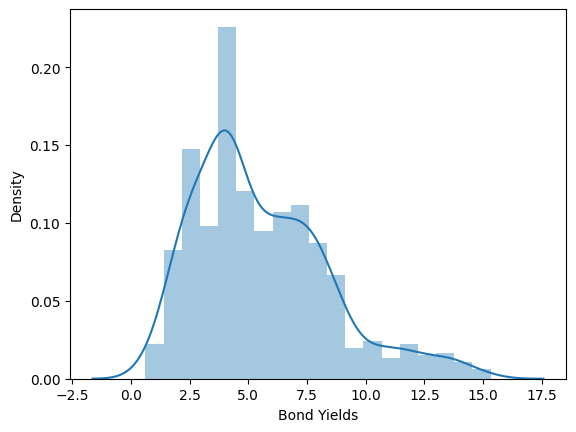

In [ ]:
sns.distplot(df['Bond Yields'])

We can see that the distribution looks skewed to the left and we can convert the outlier values into a missing value and impute accordingly

In [ ]:
def convert_outliers_to_nan(df, column, method='iqr', threshold=1.5):
    """Converts outliers in the given column to NaN values."""

    if method == 'iqr':
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), np.nan, df[column])
    else:
        raise ValueError("Invalid method. Supported methods are: 'iqr'")

    return df

df = convert_outliers_to_nan(df, 'Bond Yields', method='iqr')
df['Bond Yields'] = df['Bond Yields'].fillna(method='ffill')

<ipython-input-253-f096ae3aec8d>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Bond Yields'] = df['Bond Yields'].fillna(method='ffill')


<ipython-input-254-fe35e4d673f7>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Bond Yields'])


<Axes: xlabel='Bond Yields', ylabel='Density'>

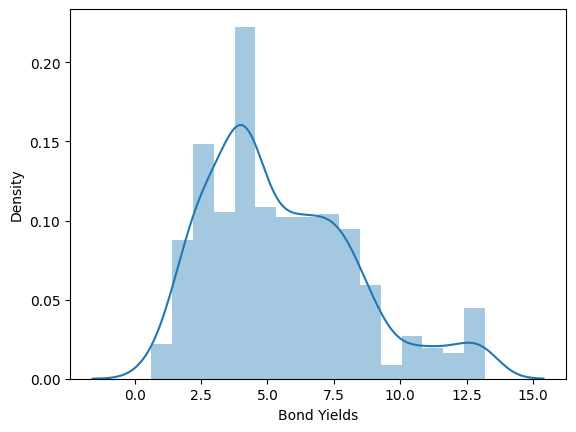

In [ ]:
sns.distplot(df['Bond Yields'])

Inflation Rate

In [ ]:
df['Inflation Rate'].describe()

,Inflation Rate
count,932.000000
mean,120.684666
std,86.340438
min,21.480000
25%,32.372500
50%,108.600000
75%,193.225000
max,314.121000


<ipython-input-256-d1a818c85efb>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Inflation Rate'])


<Axes: xlabel='Inflation Rate', ylabel='Density'>

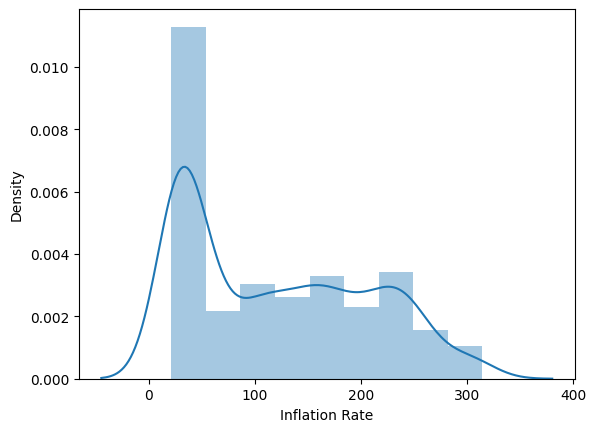

In [ ]:
sns.distplot(df['Inflation Rate'])

We can see that there is a major skew towards the left and outliers such as 350 can be imputed again

In [ ]:
df = convert_outliers_to_nan(df, 'Inflation Rate', method='iqr')
df['Inflation Rate'] = df['Inflation Rate'].fillna(method='ffill')

<ipython-input-257-8195e8aacb0f>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Inflation Rate'] = df['Inflation Rate'].fillna(method='ffill')


<ipython-input-258-d1a818c85efb>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Inflation Rate'])


<Axes: xlabel='Inflation Rate', ylabel='Density'>

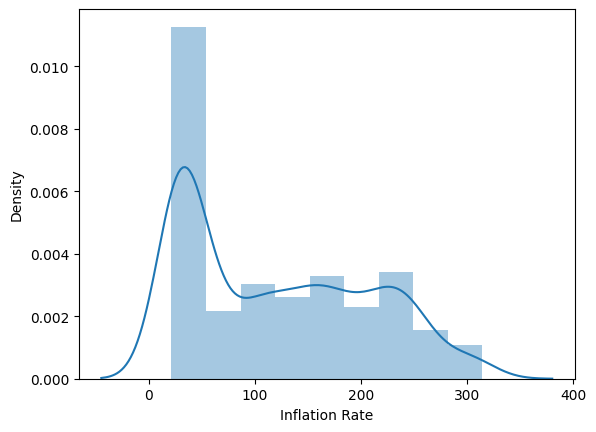

In [ ]:
sns.distplot(df['Inflation Rate'])

Looks like there was not much of a change even after applying the imputation to remive outliers so we can use the data as is.

Unemployment Rate

In [ ]:
df['Unemployment Rate'].describe()

,Unemployment Rate
count,921.000000
mean,5.688056
std,1.709770
min,2.500000
25%,4.400000
50%,5.500000
75%,6.700000
max,14.800000


<ipython-input-260-1ac451451bba>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Unemployment Rate'])


<Axes: xlabel='Unemployment Rate', ylabel='Density'>

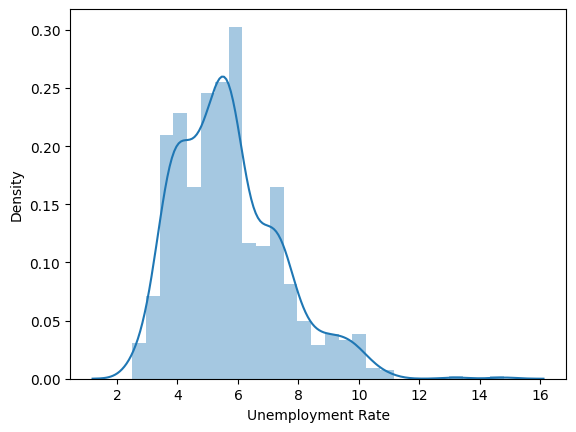

In [ ]:
sns.distplot(df['Unemployment Rate'])

There definitely are alot of outliers in this data so we can try to make the distribution more towards a normal distribution

In [ ]:
df = convert_outliers_to_nan(df, 'Unemployment Rate', method='iqr')
df['Unemployment Rate'] = df['Unemployment Rate'].fillna(method='ffill')

<ipython-input-261-25a57329b2aa>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Unemployment Rate'] = df['Unemployment Rate'].fillna(method='ffill')


<ipython-input-262-1ac451451bba>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Unemployment Rate'])


<Axes: xlabel='Unemployment Rate', ylabel='Density'>

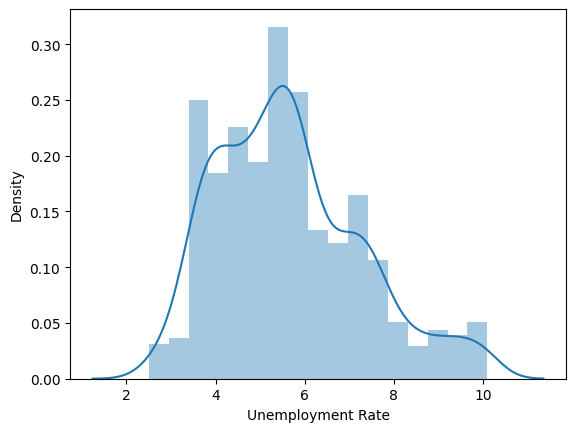

In [ ]:
sns.distplot(df['Unemployment Rate'])

GDP growth Rate

In [ ]:
df['GDP Growth'].describe()

,GDP Growth
count,310.000000
mean,10061.600087
std,6139.577424
min,2172.432000
25%,4758.098000
50%,8636.204000
75%,15801.265250
max,23223.906000


<ipython-input-264-dee8288f8650>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['GDP Growth'])


<Axes: xlabel='GDP Growth', ylabel='Density'>

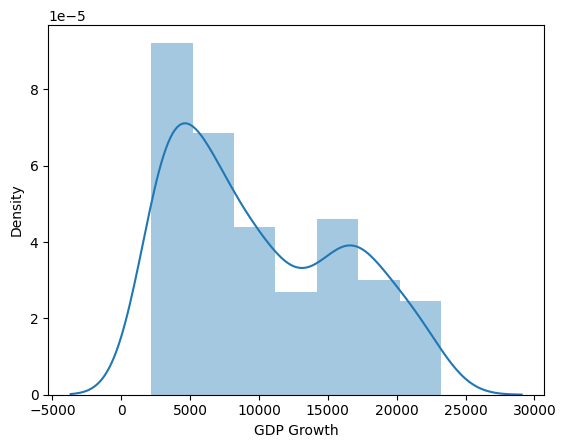

In [ ]:
sns.distplot(df['GDP Growth'])

In [ ]:
df = convert_outliers_to_nan(df, 'GDP Growth', method='iqr')
df['GDP Growth'] = df['GDP Growth'].fillna(method='ffill')

<ipython-input-265-7cd98ce1a9df>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['GDP Growth'] = df['GDP Growth'].fillna(method='ffill')


<ipython-input-266-dee8288f8650>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['GDP Growth'])


<Axes: xlabel='GDP Growth', ylabel='Density'>

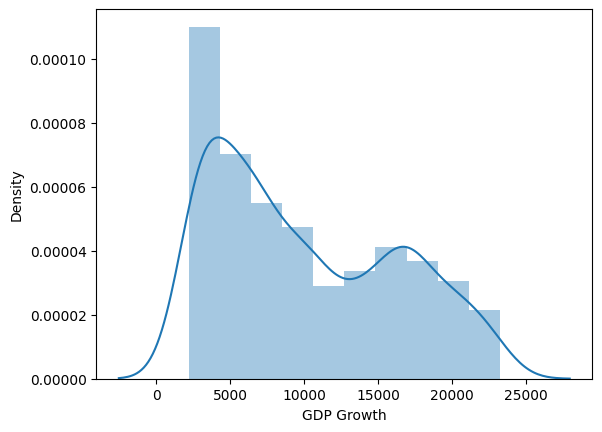

In [ ]:
sns.distplot(df['GDP Growth'])

Now that the outliers are removed, lets move on to checking to see if there are null values and how we will deal with them

In [ ]:
print(df.shape)
df.isnull().sum()

(933, 4)


,0
Bond Yields,75
Inflation Rate,0
Unemployment Rate,12
GDP Growth,0


We can see that bond yields and Unmeployment Rate have null values that need to be handled. In this situation since the data is continous the best way to handle the missing values in Bond yields and Unemployment Rate would be to impute it using the mean values (Check later....)

In [ ]:
df['Bond Yields'] = df['Bond Yields'].fillna(df['Bond Yields'].mean())
df['Unemployment Rate'] = df['Unemployment Rate'].fillna(df['Unemployment Rate'].mean())

In [ ]:
df.isnull().sum()

,0
Bond Yields,0
Inflation Rate,0
Unemployment Rate,0
GDP Growth,0


Now that we have successfully dealt with null values lets move on to Univariate analysis

Bond yields:

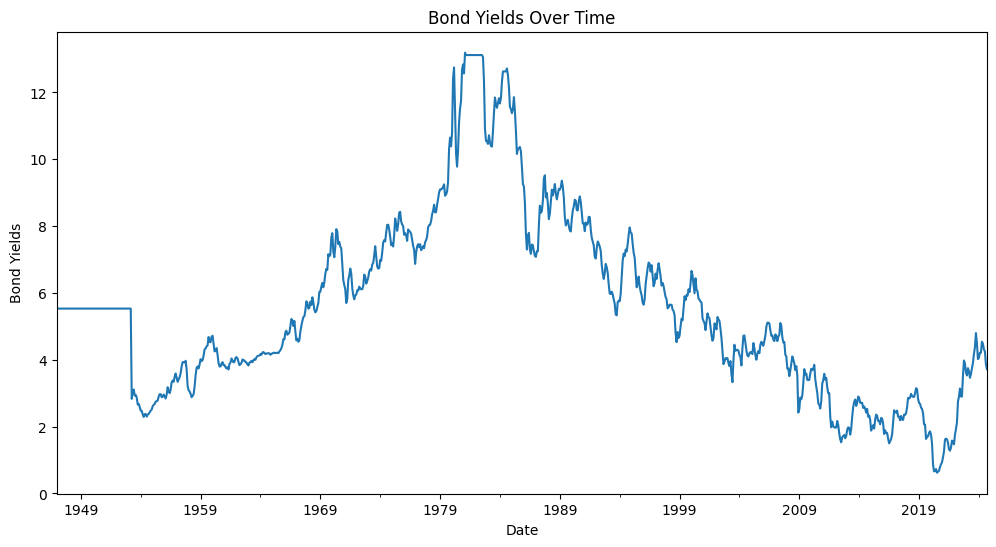

In [ ]:
df['Bond Yields'].plot(figsize=(12, 6))
plt.title('Bond Yields Over Time')
plt.xlabel('Date')
plt.ylabel('Bond Yields')
plt.show()


The hightest peak in the Bond Yield was during the time of 1979 - 1989 after that there has been a huge dip from 2009 - 2019 with the lowest dip in 2020 and slowly started to pick by 2021

Inflation Rate

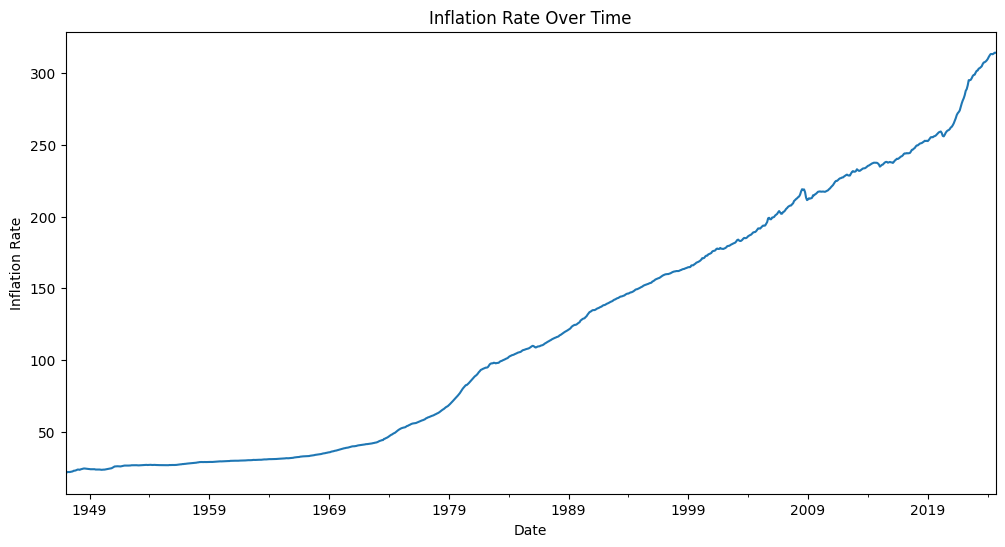

In [ ]:
df['Inflation Rate'].plot(figsize=(12, 6))
plt.title('Inflation Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Inflation Rate')
plt.show()

There seems to be a steeper increase in the inflation rate from 2019 till then the increase seem uniform

Unemployment Rate

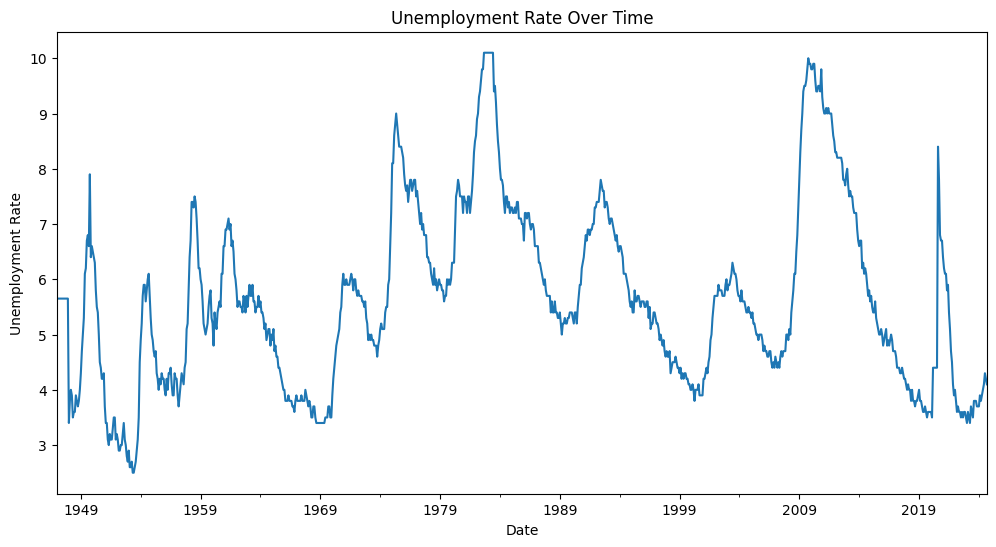

In [ ]:
df['Unemployment Rate'].plot(figsize=(12, 6))
plt.title('Unemployment Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.show()

There was a peak in unemployment Rate from 2009 -2018 and another peak from 2020 - 2021

GDP Rate

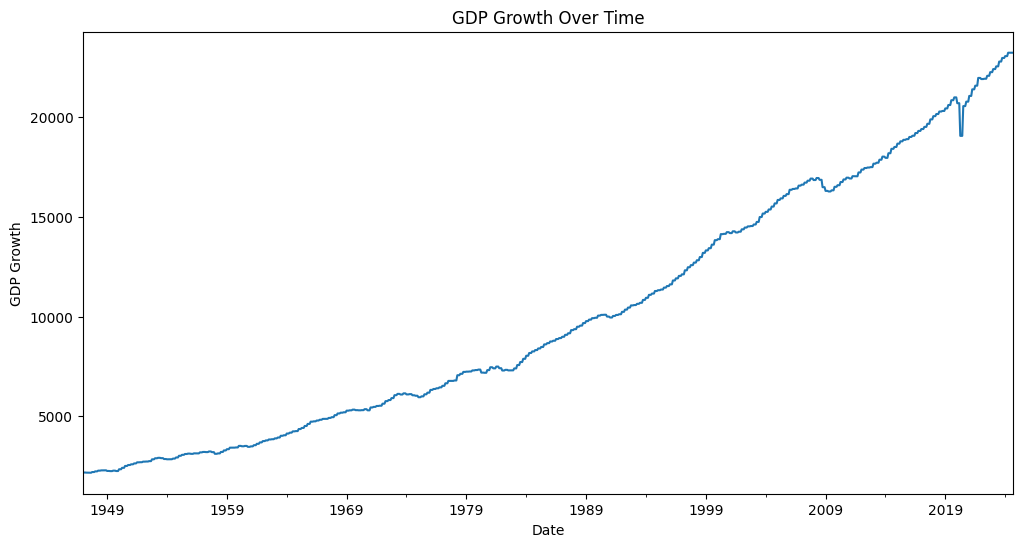

In [ ]:
df['GDP Growth'].plot(figsize=(12, 6))
plt.title('GDP Growth Over Time')
plt.xlabel('Date')
plt.ylabel('GDP Growth')
plt.show()

Bivariate analysis

<function matplotlib.pyplot.show(close=None, block=None)>

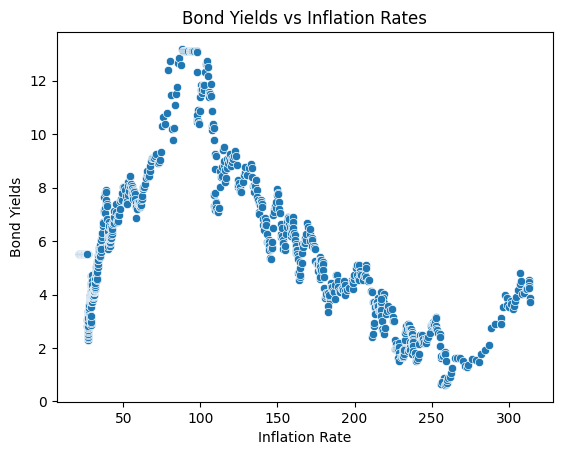

In [ ]:
#Bond yield vs Inflation Rates
sns.scatterplot(x='Inflation Rate', y='Bond Yields', data=df)
plt.title('Bond Yields vs Inflation Rates')
plt.xlabel('Inflation Rate')
plt.ylabel('Bond Yields')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

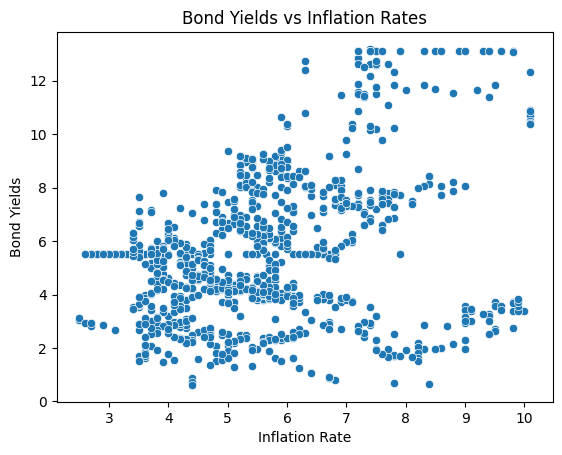

In [ ]:
#Bond yield vs Unemployment Rates
sns.scatterplot(x='Unemployment Rate', y='Bond Yields', data=df)
plt.title('Bond Yields vs Inflation Rates')
plt.xlabel('Inflation Rate')
plt.ylabel('Bond Yields')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

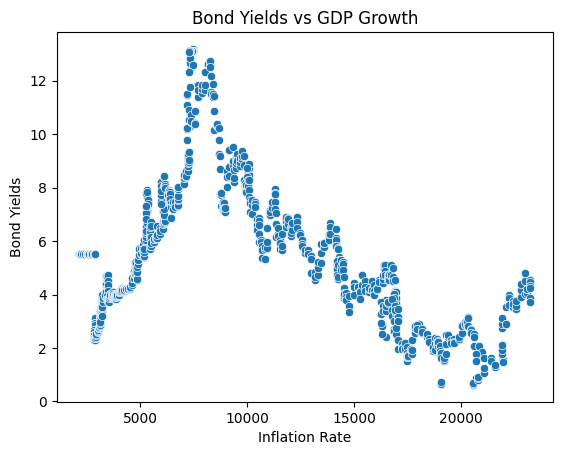

In [ ]:
sns.scatterplot(x='GDP Growth', y='Bond Yields', data=df)
plt.title('Bond Yields vs GDP Growth')
plt.xlabel('Inflation Rate')
plt.ylabel('Bond Yields')
plt.show

Multivariate analysis

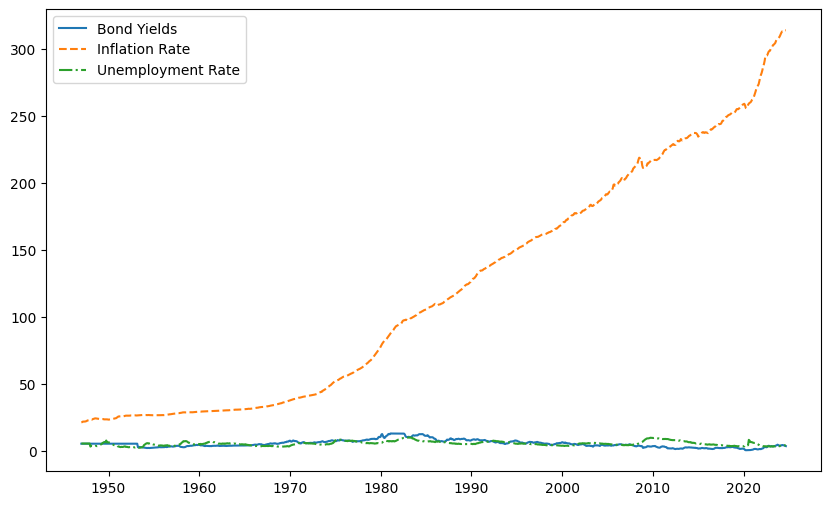

In [ ]:
df['Date'] = df.index  # Assuming the index is the date
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Bond Yields'], label='Bond Yields')
plt.plot(df['Date'], df['Inflation Rate'], label='Inflation Rate', linestyle='--')
plt.plot(df['Date'], df['Unemployment Rate'], label='Unemployment Rate', linestyle='-.')
plt.legend()
plt.show()

In [ ]:
df.corr()

,Bond Yields,Inflation Rate,Unemployment Rate,GDP Growth,Date
Bond Yields,1.000000,-0.352819,0.337144,-0.375020,-0.247458
Inflation Rate,-0.352819,1.000000,0.059242,0.993374,0.975084
Unemployment Rate,0.337144,0.059242,1.000000,0.025805,0.130505
GDP Growth,-0.375020,0.993374,0.025805,1.000000,0.981658
Date,-0.247458,0.975084,0.130505,0.981658,1.000000


In [ ]:
df.corr().style.background_gradient(cmap='coolwarm')

,Bond Yields,Inflation Rate,Unemployment Rate,GDP Growth,Date
Bond Yields,1.000000,-0.352819,0.337144,-0.375020,-0.247458
Inflation Rate,-0.352819,1.000000,0.059242,0.993374,0.975084
Unemployment Rate,0.337144,0.059242,1.000000,0.025805,0.130505
GDP Growth,-0.375020,0.993374,0.025805,1.000000,0.981658
Date,-0.247458,0.975084,0.130505,0.981658,1.000000


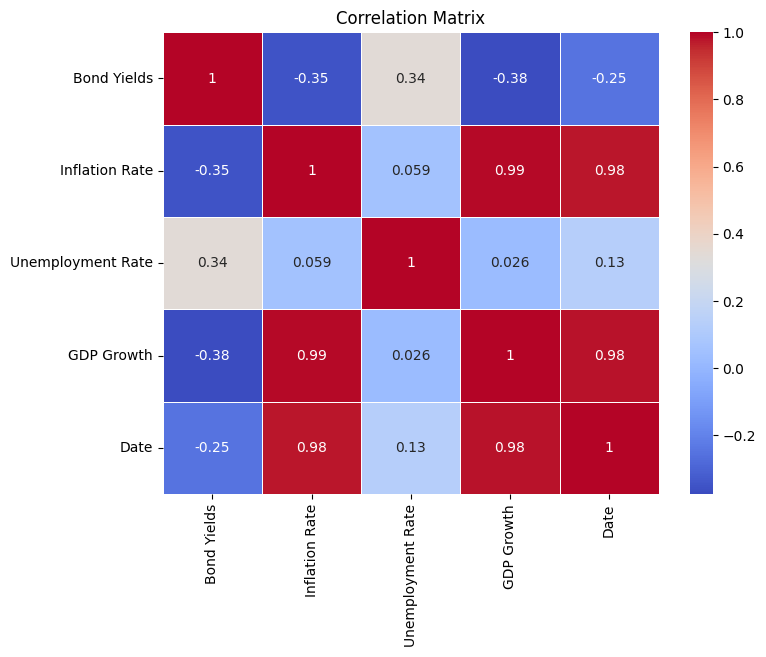

In [ ]:
corr_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

The bond yields are negatively correlated to Inflation Rate and GDP Growth Rate while positively correlated with unemployment but its not too strong

We can also see that the Inflation Rate and the GDP Growth are highly correlated

Regression Modelling

In [ ]:
from re import X
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

X = df[['Inflation Rate', 'Unemployment Rate', 'GDP Growth']]
y = df['Bond Yields']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

model = LinearRegression()
model.fit(x_train_scaled, y_train)

y_pred = model.predict(x_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 4.883781918528296
R-squared: 0.303499767953496


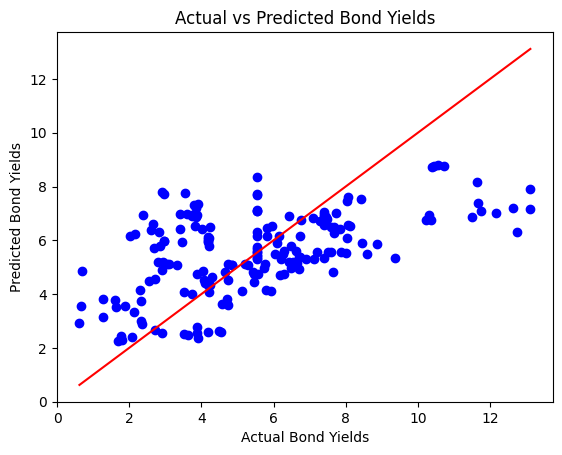

In [ ]:
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Bond Yields')
plt.ylabel('Predicted Bond Yields')
plt.title('Actual vs Predicted Bond Yields')
plt.show()

In [ ]:
y_pred

array([3.55572082, 5.31104984, 4.09808881, 5.35826039, 4.08764999,
       6.40195352, 6.74629108, 6.93021827, 6.53752129, 7.00923051,
       6.99058416, 7.19766306, 5.12014474, 8.72404461, 5.10952598,
       4.75367743, 6.50968998, 7.40296476, 7.09320487, 6.901579  ,
       4.83937419, 5.55141251, 6.57560455, 7.67838292, 7.9138657 ,
       5.36728321, 2.93804755, 4.98513935, 6.41711732, 4.72707563,
       6.48264735, 5.68610556, 7.11222677, 5.48543121, 4.65068448,
       4.53528925, 6.87931951, 8.77568927, 6.24499863, 5.94355641,
       5.41190067, 5.55100469, 5.56126587, 6.53316059, 5.51532033,
       4.56033943, 2.56025937, 6.14223132, 3.81573175, 5.31272793,
       6.98452898, 5.91287124, 7.78399442, 4.09823322, 6.17490229,
       5.09727396, 5.06757161, 6.76705616, 3.56138492, 6.6195277 ,
       6.4585909 , 5.38531417, 4.14556295, 2.54809397, 7.72769565,
       6.13067046, 6.42615511, 5.20457908, 2.64838432, 5.86908242,
       2.52780761, 6.41787431, 6.31888258, 6.87792812, 6.81169

In [ ]:
#get the features that affected the prediction the most
model_features = pd.DataFrame({'Feature': ['Inflation Rate', 'Unemployment Rate', 'GDP Growth'], 'Coefficient': model.coef_})
print(model_features)

             Feature  Coefficient
0     Inflation Rate     1.758300
1  Unemployment Rate     0.880599
2         GDP Growth    -2.772603


This code is ideally supposed to give GDP Growth to be positively imapcting the Bond Yields for predicting. These unexpected results can be due to Multi-Collinearity between GDP Growth and Inflation Rate as they were highly correlated.

So we can try experimenting with L2 Regularization(Ridge Regression to see if the results improve)

Regression using Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

X = df[['Inflation Rate', 'Unemployment Rate', 'GDP Growth']]
y = df['Bond Yields']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

ridge_model = Ridge(alpha=50000.0)  # You can tune alpha to be higher for stronger regularization
ridge_model.fit(x_train_scaled, y_train)

y_pred = ridge_model.predict(x_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 6.924115504095634
R-squared: 0.012517729953697931


In [ ]:
coefficients = pd.DataFrame(ridge_model.coef_, X.columns, columns=['Ridge Coefficients'])
print(coefficients)

                   Ridge Coefficients
Inflation Rate              -0.013643
Unemployment Rate            0.013415
GDP Growth                  -0.014519


In [ ]:
from sklearn.linear_model import RidgeCV

# RidgeCV automatically tunes the alpha value by cross-validation
alphas = [0.1, 1.0, 10.0, 100.0]  # List of alpha values to try
ridge_cv = RidgeCV(alphas=alphas, cv=5)

# Fit the model
ridge_cv.fit(X_train_scaled, y_train)

# Best alpha value
print(f"Best alpha: {ridge_cv.alpha_}")

# Predict on the test set
y_pred_cv = ridge_cv.predict(X_test_scaled)

# Evaluate the model
mse_cv = mean_squared_error(y_test, y_pred_cv)
r2_cv = r2_score(y_test, y_pred_cv)

print(f"Mean Squared Error with CV: {mse_cv}")
print(f"R-squared with CV: {r2_cv}")

Best alpha: 0.1
Mean Squared Error with CV: 4.8840503208548816
R-squared with CV: 0.30346148977362075
